### Metrics calculation and some plots
Use this notebook to calculate the Dice scores for the images the network was not trained on. This works for the registration predictions as well as U-Net predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [1]:
nca_exps = '/local/scratch/aranem/NeurIPS_2023/NeurIPS_2023_predictions/VoxelMorph_NCA'
vxm_exps = '/local/scratch/aranem/NeurIPS_2023/NeurIPS_2023_predictions/VoxelMorph'

#### Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, pystrum, copy
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.autograd import Variable

os.environ['NEURITE_BACKEND'] = "pytorch"
import neurite as ne

/home/aranem_locale/anaconda3/envs/Lifelong-nnUNet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Helpful functions and other stuffs

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def mean_dice_coef(y_true, y_pred_bin, num_classes=1, do_torch=False):
    # from: https://www.codegrepper.com/code-examples/python/dice+similarity+coefficient+python
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    depth = y_true.shape[-1]
    # channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    # dict contains label: dice per batch
    channel_dices_per_batch = {i+1:list() for i in range(num_classes)}
    for i in range(batch_size):
        # for n in range(depth):
        for j in range(1, num_classes+1):
            y_t = y_true[i, ...].clone() if do_torch else copy.deepcopy(y_true[i, ...])
            y_p = y_pred_bin[i, ...].clone() if do_torch else copy.deepcopy(y_pred_bin[i, ...])
            y_t[y_t != j] = 0
            y_t[y_t == j] = 1
            y_p[y_p != j] = 0
            y_p[y_p == j] = 1
            channel_dice = single_dice_coef(y_t, y_p, do_torch)
            channel_dices_per_batch[j].append(channel_dice)
            # channel_dice = single_dice_coef(y_true[i, :, :, j], y_pred_bin[i, :, :, j], num_classes, do_torch)
            mean_dice_channel += channel_dice/(num_classes*batch_size)
    return mean_dice_channel, channel_dices_per_batch

def single_dice_coef(y_true, y_pred_bin, do_torch=False):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin) if not do_torch else torch.sum(y_true * y_pred_bin)
    if do_torch:
        if (torch.sum(y_true)==0) and (torch.sum(y_pred_bin)==0):
            return 1
        return ((2*intersection) / (torch.sum(y_true) + torch.sum(y_pred_bin))).item()
    else:
        if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
            return 1
        return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

hip_keys = ['Hippocampus_Dryad_0'+"%03d" % x for x in range(1, 31)]
hip_keys.extend(['Hippocampus_Harp_0'+"%03d" % x for x in range(1, 31)])

prost_keys = ['Prostate_HK_0'+ str(x) for x in range(121, 151)]
prost_keys.extend(['Prostate_I2CVB_0'+ str(x) for x in range(121, 151)])
    
val_keys = {'Task210_OASIS': ['OASIS_0'+str(x) for x in range(365, 415)],
            'Task211_Prostate': prost_keys,
            'Task212_Hippocampus': hip_keys}

### VoxelMorph results

In [4]:
#models = ['vxm_nca_torch_250_210_ncc_kernel_7_30_db_unet_CONCAT']#[x for x in os.listdir(vxm_exps) if 'vxm' in x]
models = [x for x in os.listdir(vxm_exps) if 'vxm' in x]

models.sort()
dices_v = dict()
jcp_nv = dict()
mse_nv = dict()
mse_nmv = dict()
dices_v_violin = dict()
for model in models:
    dices_v[model] = dict()
    jcp_nv[model] = dict()
    mse_nv[model] = dict()
    mse_nmv[model] = dict()
    dices_v_violin[model] = list()
    preds = os.path.join(vxm_exps, model, 'predictions')
    # -- Load the data -- #
    try:
        ds = [x for x in os.listdir(preds)]
        ds.sort()
        print(f'Dice for model {model}:')
    except:
        continue
    for datas in ds:
        dices_ = list()
        jcb_v = list()
        mse_v = list()
        mse_n = list()
        dices_nmv = list()
        dices_v[model][datas] = dict()
        jcp_nv[model][datas] = dict()
        mse_nv[model][datas] = dict()
        mse_nmv[model][datas] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_v[model][datas][case] = dict()
            jcp_nv[model][datas][case] = dict()
            mse_nv[model][datas][case] = dict()
            mse_nmv[model][datas][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
            y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_v[model][datas][case]['moved'] = np.round(dice, 4)
            dices_.append(dice)
            
            transform = sitk.ReadImage(os.path.join(preds, datas, case, 'flow.nii.gz'), sitk.sitkVectorFloat64)   ## the deformation field was saved as 'transform.txt'
            outTx = sitk.DisplacementFieldTransform(transform)
            v = sitk.DisplacementFieldJacobianDeterminant(outTx.GetDisplacementField())
            jcb = sitk.GetArrayFromImage(v)    ##jcb is the Jacobian determinant array
            jcb_neg = np.count_nonzero(jcb <= 0)
            jcb_pos = np.count_nonzero(jcb > 0)
            jcb_all= jcb_neg + jcb_pos
            jcp_nv[model][datas][case]['jcb_neg'] = jcb_neg
            jcp_nv[model][datas][case]['jcb_pos'] = jcb_pos
            jcp_nv[model][datas][case]['jcb_all'] = jcb_all
            jcp_nv[model][datas][case]['jcb_neg_perc'] = jcb_neg/jcb_all
            # perc = jcb_neg/jcb_all
            jcb_v.append(jcb_neg)
            
            _, channel_dices_per_batch = mean_dice_coef(gt, y_nm, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moving and fixed segmentation
            dices_v[model][datas][case]['not_moved'] = np.round(dice, 4)
            dices_v_violin[model].append(np.round(dice, 4))
            dices_nmv.append(dice)
            
            MSE = np.square(np.subtract(gt, y_p)).mean()
            mse_nv[model][datas][case]['mse'] = MSE
            mse_v.append(MSE)
            
            MSE_ = np.square(np.subtract(gt, y_nm)).mean()
            mse_nmv[model][datas][case]['mse'] = MSE_
            mse_n.append(MSE_)

        print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 
        print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmv), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_nmv), decimals=4)*100, 2)} %.")
        print(f"{datas} jcb <= 0: Mean jcb +/- std: {trunc(np.round(np.mean(jcb_v), decimals=4), 2)} +/- {trunc(np.round(np.std(jcb_v), decimals=4), 2)}.")
        print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_v), decimals=4), 2)} +/- {trunc(np.round(np.std(mse_v), decimals=4), 2)}.")
        print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} +/- {trunc(np.round(np.std(mse_n), decimals=4), 2)}.")

        dices_v[model][datas]['mean_dice_moved'] = np.mean(dices_)
        dices_v[model][datas]['mean_std_moved'] = np.std(dices_)
        dices_v[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
        dices_v[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
        dices_v[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
        dices_v[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
    print()

Dice for model vxm_torch_250_210_ncc_ce:
Task210_OASIS: Mean dice +/- std: 84.59 % +/- 1.5 %.
Task210_OASIS nm: Mean dice +/- std: 68.56 % +/- 1.67 %.
Task210_OASIS jcb <= 0: Mean jcb +/- std: 1274.61 +/- 567.78.
Task210_OASIS mean MSE +/- std: 7.48 +/- 0.75.
Task210_OASIS nm: mean MSE +/- std: 15.08 +/- 1.28.

Dice for model vxm_torch_250_210_ncc_ce_bias_level_1:
Task210_OASIS: Mean dice +/- std: 81.14 % +/- 2.13 %.
Task210_OASIS nm: Mean dice +/- std: 68.56 % +/- 1.67 %.
Task210_OASIS jcb <= 0: Mean jcb +/- std: 637.29 +/- 559.68.
Task210_OASIS mean MSE +/- std: 8.68 +/- 0.99.
Task210_OASIS nm: mean MSE +/- std: 15.08 +/- 1.28.

Dice for model vxm_torch_250_210_ncc_ce_bias_level_2:
Task210_OASIS: Mean dice +/- std: 76.84 % +/- 3.02 %.
Task210_OASIS nm: Mean dice +/- std: 68.56 % +/- 1.67 %.
Task210_OASIS jcb <= 0: Mean jcb +/- std: 415.18 +/- 590.95.
Task210_OASIS mean MSE +/- std: 10.55 +/- 1.43.
Task210_OASIS nm: mean MSE +/- std: 15.08 +/- 1.28.

Dice for model vxm_torch_250_210_n

### NCA results

In [5]:
models = [x for x in os.listdir(nca_exps) if 'nca' in x]
models.sort()
dices_u = dict()
jcp_nn = dict()
mse_nn = dict()
dices_u_violin = dict()
for model in models:
    dices_u[model] = dict()
    dices_u_violin[model] = list()
    jcp_nn[model] = dict()
    mse_nn[model] = dict()
    preds = os.path.join(nca_exps, model, 'predictions')
    # -- Load the data -- #
    try:
        ds = [x for x in os.listdir(preds)]
        ds.sort()
        print(f'Dice for model {model}:')
    except:
        continue
    for datas in ds:
        dices_ = list()
        jcb_n = list()
        mse_n = list()
        dices_nmn = list()
        dices_u[model][datas] = dict()
        jcp_nn[model][datas] = dict()
        mse_nn[model][datas] = dict()
        cases = val_keys[datas]
        for case in cases:
            dices_u[model][datas][case] = dict()
            jcp_nn[model][datas][case] = dict()
            mse_nn[model][datas][case] = dict()
            gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
            y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
            y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
            _, channel_dices_per_batch = mean_dice_coef(gt, y_p, 1, False)
            dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moved and fixed segmentation
            dices_u[model][datas][case]['moved'] = np.round(dice, 4)
            dices_u_violin[model].append(np.round(dice, 4))
            dices_.append(dice)
            
            transform = sitk.ReadImage(os.path.join(preds, datas, case, 'flow.nii.gz'), sitk.sitkVectorFloat64)   ## the deformation field was saved as 'transform.txt'
            outTx = sitk.DisplacementFieldTransform(transform)
            v = sitk.DisplacementFieldJacobianDeterminant(outTx.GetDisplacementField())
            jcb = sitk.GetArrayFromImage(v)    ##jcb is the Jacobian determinant array
            jcb_neg = np.count_nonzero(jcb <= 0)
            jcb_pos = np.count_nonzero(jcb > 0)
            jcb_all= jcb_neg + jcb_pos
            jcp_nn[model][datas][case]['jcb_neg'] = jcb_neg
            jcp_nn[model][datas][case]['jcb_pos'] = jcb_pos
            jcp_nn[model][datas][case]['jcb_all'] = jcb_all
            jcp_nn[model][datas][case]['jcb_neg_perc'] = jcb_neg/jcb_all
            # perc = jcb_neg/jcb_all
            jcb_n.append(jcb_neg)
            
            # _, channel_dices_per_batch = mean_dice_coef(gt, y_nm, 1, False)
            # dice = [np.mean(v) for _, v in channel_dices_per_batch.items()] # Dice between moving and fixed segmentation
            # dices_u[model][datas][case]['not_moved'] = np.round(dice, 4)
            # dices_u_violin[model].append(np.round(dice, 4))
            # dices_nmn.append(dice)

            MSE = np.square(np.subtract(gt, y_p)).mean()
            mse_nn[model][datas][case]['mse'] = MSE
            mse_n.append(MSE)
            
        print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_), decimals=4)*100, 2)} %.") 
        # print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmn), decimals=4)*100, 2)} % +/- {trunc(np.round(np.std(dices_nmn), decimals=4)*100, 2)} %.")
        print(f"{datas} jcb <= 0: Mean jcb +/- std: {trunc(np.round(np.mean(jcb_n), decimals=4), 2)} +/- {trunc(np.round(np.std(jcb_n), decimals=4), 2)}.")
        print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} +/- {trunc(np.round(np.std(mse_n), decimals=4), 2)}.")


        dices_u[model][datas]['mean_dice_moved'] = np.mean(dices_)
        dices_u[model][datas]['mean_std_moved'] = np.std(dices_)
        dices_u[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_), 4))
    print()

Dice for model vxm_nca_torch_250_210_ncc_kernel_3_3_30:
Task210_OASIS: Mean dice +/- std: 78.62 % +/- 1.58 %.
Task210_OASIS jcb <= 0: Mean jcb +/- std: 450.94 +/- 376.85.
Task210_OASIS mean MSE +/- std: 10.24 +/- 0.76.

Dice for model vxm_nca_torch_250_210_ncc_kernel_5_5_30:
Task210_OASIS: Mean dice +/- std: 75.22 % +/- 1.45 %.
Task210_OASIS jcb <= 0: Mean jcb +/- std: 771.82 +/- 798.15.
Task210_OASIS mean MSE +/- std: 12.17 +/- 0.95.

Dice for model vxm_nca_torch_250_210_ncc_kernel_7_7_10:
Task210_OASIS: Mean dice +/- std: 80.17 % +/- 1.59 %.
Task210_OASIS jcb <= 0: Mean jcb +/- std: 1512.42 +/- 546.36.
Task210_OASIS mean MSE +/- std: 9.75 +/- 0.77.

Dice for model vxm_nca_torch_250_210_ncc_kernel_7_7_10_bias_level_1:
Task210_OASIS: Mean dice +/- std: 77.18 % +/- 2.41 %.
Task210_OASIS jcb <= 0: Mean jcb +/- std: 791.74 +/- 903.46.
Task210_OASIS mean MSE +/- std: 10.84 +/- 1.11.

Dice for model vxm_nca_torch_250_210_ncc_kernel_7_7_10_bias_level_2:
Task210_OASIS: Mean dice +/- std: 73.9

In [41]:
# Kernel size
data_kernel = pd.DataFrame([], columns=['Kernel Size', 'Dice'], dtype=float)
meandata_kernel = pd.DataFrame([], columns=['Kernel Size', 'Dice', 'STD'], dtype=float)
for i, (k, v) in enumerate(dices_u_violin.items()):
    if len(k) > 39 or k[-2:] != '30':
        continue
    
    for v_ in v:
        row = {'Kernel Size': k.split('_')[-2] + " $\times " + k.split('_')[-2], 'Dice': float(v_[0])}
        new_df = pd.DataFrame([row])
        data_kernel = pd.concat([data_kernel, new_df], axis=0, ignore_index=True)
    row_mean = {'Kernel Size':  k.split('_')[-2] + " $\times " + k.split('_')[-2], 'Dice': np.mean(v), 'STD': np.std(v)}#, 'Method': 'NCA-Morph'}
    new_df_mean = pd.DataFrame([row_mean])
    meandata_kernel = pd.concat([meandata_kernel, new_df_mean], axis=0, ignore_index=True)


# Nr of steps
data_steps = pd.DataFrame([], columns=['Step Size', 'Dice'], dtype=float)
meandata_steps = pd.DataFrame([], columns=['Step Size', 'Dice', 'STD'], dtype=float)
for i, (k, v) in enumerate(dices_u_violin.items()):
    if len(k) > 39 or k[-6:-3] != '7_7':
        continue
    
    for v_ in v:
        row = {'Step Size': k[-2:], 'Dice': float(v_[0])}
        new_df = pd.DataFrame([row])
        data_steps = pd.concat([data_steps, new_df], axis=0, ignore_index=True)
    row_mean = {'Step Size':  k[-2:], 'Dice': np.mean(v), 'STD': np.std(v)}#, 'Method': 'NCA-Morph'}
    new_df_mean = pd.DataFrame([row_mean])
    meandata_steps = pd.concat([meandata_steps, new_df_mean], axis=0, ignore_index=True)

    
# Robustness
data_robustness = pd.DataFrame([], columns=['Method', 'Dice', 'Artifact'], dtype=float)
meandata_robustness = pd.DataFrame([], columns=['Method', 'Dice', 'STD', 'Artifact'], dtype=float)
for i, (k, v) in enumerate(dices_u_violin.items()):
    if 'ncc_kernel_7_7_10' in k and 'fire' not in k:
        artifact = "bias" if "bias" in k else "spike"  if "spike" in k else "ghosting" if "ghosting" in k else "none"
        for v_ in v:
            row = {'Method': "NCA-Morph$_{7 \times 7}^{10}$", 'Dice': float(v_[0]), 'Artifact': artifact}
            new_df = pd.DataFrame([row])
            data_robustness = pd.concat([data_robustness, new_df], axis=0, ignore_index=True)
        row_mean = {'Method':  "NCA-Morph$_{7 \times 7}^{10}$", 'Dice': np.mean(v), 'STD': np.std(v), 'Artifact': artifact}
        new_df_mean = pd.DataFrame([row_mean])
        meandata_robustness = pd.concat([meandata_robustness, new_df_mean], axis=0, ignore_index=True)
for i, (k, v) in enumerate(dices_v_violin.items()):
    artifact = "bias" if "bias" in k else "spike"  if "spike" in k else "ghosting" if "ghosting" in k else "none"
    for v_ in v:
        row = {'Method': "VoxelMorph", 'Dice': float(v_[0]), 'Artifact': artifact}
        new_df = pd.DataFrame([row])
        data_robustness = pd.concat([data_robustness, new_df], axis=0, ignore_index=True)
    row_mean = {'Method':  "VoxelMorph", 'Dice': np.mean(v), 'STD': np.std(v), 'Artifact': artifact}
    new_df_mean = pd.DataFrame([row_mean])
    meandata_robustness = pd.concat([meandata_robustness, new_df_mean], axis=0, ignore_index=True)

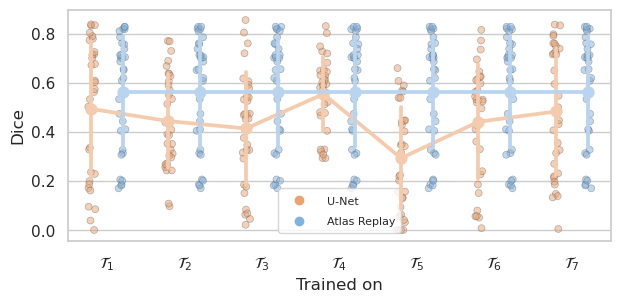

In [47]:
plt.figure(figsize=(7, 3))

# Plot
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.pointplot(data=data, x="Trained on", y="Dice", errorbar="sd", hue='Method', palette=[adjust_lightness('#fae5d6', 0.9), adjust_lightness('#deebf7', 0.9)], dodge=0.41)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.stripplot(x="Trained on", y="Dice", data=data, hue='Method', palette=[adjust_lightness('#fae5d6', 0.75), adjust_lightness('#deebf7', 0.75)], dodge=0.15, alpha=0.5, linewidth=0.5)#, jitter=False)
plt.legend(loc='lower center', title='')
plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('/home/jkalkhof_locale/Documents/temp/NeurIps/scatter_simple_unet_vxm.pdf', bbox_inches='tight')